Para todas as tarefas foi considerado uma resistência interna de $10~\mathrm{M}\Omega$ para o voltímetro, como diz no manual.<br>
ATENÇÃO: os valores de capacitância estão todos dados em micro Farad.

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats, optimize
from LabIFSC import M

# Tarefa 1 - Analisar curva de carga de capacitores
Escolher três capacitores e analisar sua curva de carga com o objetivo de calcular sua capacitância pela curva.
## 1.1 Capacitores utilizados:
- $10~\mu\mathrm{F}$ (PARA O FINAL)
- $100~\mu\mathrm{F}$
- $220~\mu\mathrm{F}$
- $1000~\mu\mathrm{F}$

## 1.2 Esquema do circuito:
<img src="1.png" width="500px" />
## 1.3 Procedimento experimental:
Após montado o circuito acima, é fechado a chave e, ao mesmo tempo, manualmente disparado o cronômetro. Estes valores serão filmados com uma câmera de celular para ser feito a análise dos dados.

## 1.4 Calculo da capacitância
Equação de carga de um capacitor:
$$V(t)=V_0(1-\mathrm{e}^{-t/RC})$$

Modelo para ajuste:
$$ V(t) = V_0 (1-\mathrm{e}^{-(t+t_0)/k}) $$

Claro que $k = RC$. $V_0$ é mantido como parâmetro livre. A constante $t_0$ corrige a assincronia do disparo do cronômetro com o fechamento da chave, que é aproximadamente o tempo de reação de quem fez isso (Solano).

Note na análise seguinte que o $V_0$ assintótico diminui conforme aumentamos a capacitância (EXPLICAR).

Resistência: 101.3±0.8  kΩ

Nominal 10.0 μF
V0 = 4.45±0.03  V
RC = 1.06±0.03  s
C = 10.5±0.3  μF
t0 = -0.467±0.009  s

Nominal 100.0 μF
V0 = 4.45±0.02  V
RC = 10.8±0.2  s
C = 106±2  μF
t0 = -0.53±0.05  s

Nominal 220.0 μF
V0 = 4.42±0.03  V
RC = 22.7±0.4  s
C = 224±6  μF
t0 = -0.52±0.09  s

Nominal 1000.0 μF
V0 = 4.31±0.07  V
RC = 104±3  s
C = 1020±40  μF
t0 = -0.5±0.3  s



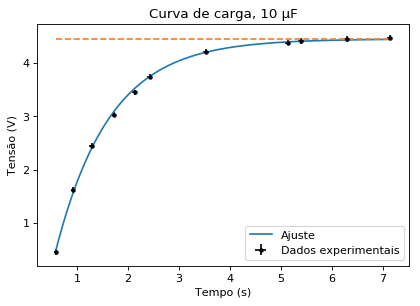

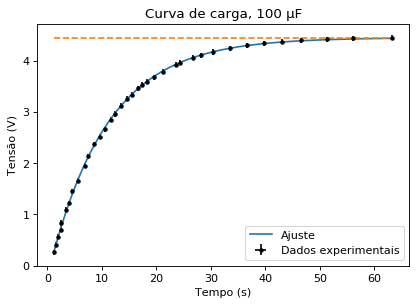

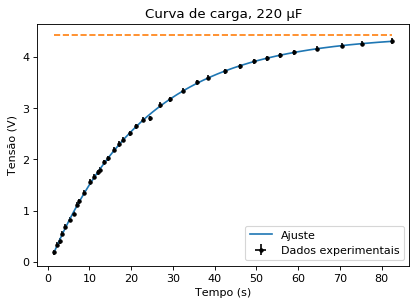

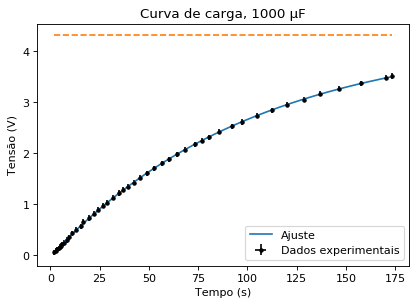

In [142]:
# Análise com parâmetro livre V0, SEM linearização
# (o problema de acurácia em t passa a importar)

err_v = lambda x: 0.005*x + 0.03
err_t = lambda x: 0.05
err_r = lambda x : 0.005*x+300

R100 = M((102.3e3,err_r(102.3e3)))
Ri = M((10e6,0))
R_tarefa1 = R100*Ri/(R100+Ri)
print("Resistência:",R_tarefa1*1e-3,"kΩ\n")
capacitores_tarefa1 = [('data/C10.dat',10e-6),
                       ('data/C100.dat',100e-6),
                       ('data/C220.dat',220e-6),
                       ('data/C1000.dat',1000e-6)]

# modelo p/ ajuste
# k = RC e t0 é o intervalo de tempo entre
# o disparo do cronômetro e a abertura da chave
# porque isso foi feito manualmente
tensao = lambda t, v0, k, t0: v0*(1-np.exp(-(t+t0)/k))

# fdados: string, nome de arquivo
# R: medida, resistência usada
def analise_carga(fdados, R, chute_C=1e-4, chute_V0=4.48):
    t,v = np.loadtxt(fdados).T
    param,mcov = optimize.curve_fit(tensao,t,v,
                            [chute_V0,R.nominal*chute_C,0],err_v(v),True)
    v0 = M((param[0], np.sqrt(mcov[0,0])))
    k = M((param[1], np.sqrt(mcov[1,1])))
    t0 = M((param[2], np.sqrt(mcov[2,2])))
    C = k/R
    return v0,k,C,t0

# fdados: string, nome de arquivo
# RC, V0, t0: medida
# C_nominal: float
def graf_carga(fdados, RC, V0, t0, C_nominal, dpi=80, titulo=None):
    t,v = np.loadtxt(fdados).T
    errot,errov = err_t(t),err_v(v)
    
    fig = plt.figure(dpi=dpi)
    plt.errorbar(t,v,errot,errov, color='k', fmt='.', label='Dados experimentais')
    tn = np.linspace(t[0],t[-1],1000)
    plt.plot(tn,tensao(tn,V0.nominal,RC.nominal,t0.nominal), label='Ajuste')
    plt.plot(t,t*0+V0,'--')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Tensão (V)')
    plt.legend()
    if titulo==None:
        titulo='Curva de carga, %.0f μF'%(C_nominal*1e6)
    plt.title(titulo)
    
    return fig # p/ poder salvar como quiser depois

res_tarefa1 = {}
for fdados,cnominal in capacitores_tarefa1:
    V0,RC,C,t0 = analise_carga(fdados,R_tarefa1,cnominal)
    res_tarefa1[int(cnominal*1e6)] = (V0,RC,C,t0)
    
    print("Nominal",cnominal*1e6,"μF\nV0 =",V0,"V")
    print("RC =",RC,"s")
    print("C =",C*1e6,"μF")
    print("t0 =",t0,"s\n")
    
    graf_carga(fdados,RC,V0,t0,cnominal)
    #fig = graf_carga(fdados,RC,V0,t0,cnominal,300)
    #fig.savefig('analise/tarefa1_{}.png'.format(int(cnominal*1e6)),bbox_inches='tight')

# Tarefa 2 - Analisar associação de capacitores
Analisar três associações de capacitores e como na primeira tarefa, obter suas curvas de carga para calcular suas capacitâncias e compara com o valor medido no capacimetro.

## 2.1 Capacitores utilizados:
- $100~\mu\mathrm{F}$
- $220~\mu\mathrm{F}$
- $1000~\mu\mathrm{F}$

In [143]:
C1 = 1e6*res_tarefa1[100][2]
C2 = 1e6*res_tarefa1[220][2]
C3 = 1e6*res_tarefa1[1000][2]
print('Capacitâncias reais:',C1,C2,C3,'(μF)')

Capacitâncias reais: 106±2  224±6  1020±40  (μF)


## 2.2 Procedimento experimental:
Medir a capacitância de cada circuito com um capacímetro e em seguida fazer a curva de carga de cada circuito, proceder como na tarefa 1.
### 2.2.1 Associação em série
$$\dfrac{1}{C}=\dfrac{1}{C_1}+\dfrac{1}{C_2}$$
<img src="2_serie.png" width="500px" />

Valor esperado nominal: 68.75 μF
Valor esperado pelas capacitancias:  72±5 μF
Valor obtido: 72±2 μF
RC = 7.3±0.1  s
t0 = -0.58±0.03  s


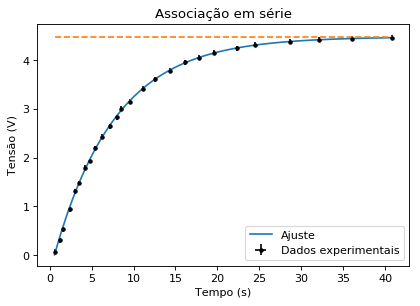

In [136]:
C_serie = lambda C1, C2 : C1*C2/(C1+C2)
serie_esp = 68.75
serie_med = C_serie(C1, C2)

fdados = 'data/A-serie-100-220.dat'

V0,RC,C,t0 = analise_carga(fdados,R_tarefa1,serie_esp)
graf_carga(fdados,RC,V0,t0,-1,80,'Associação em série')

print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias:  {:.2f}μF".format(serie_esp, serie_med))
print("Valor obtido: {}μF".format(C*1e6))
print("RC =",RC,"s")
print("t0 =",t0,"s")

### 2.2.2 Associação em paralelo
$$C=C1+C2$$
<img src="2_paralela.png" width="500px" />

Valor esperado nominal: 320 μF
Valor esperado pelas capacitancias: 331±8 μF
Valor obtido: 330±10 μF
RC = 33.4±0.7  s
t0 = -0.5±0.1  s


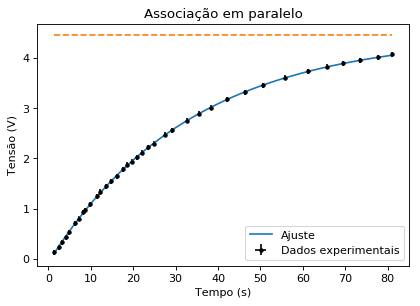

In [137]:
C_paralelo = lambda C1, C2 : C1+C2
paralelo_esp = 320
paralelo_med = C_paralelo(C1, C2)

fdados = 'data/A-paralelo-100-220.dat'

V0,RC,C,t0 = analise_carga(fdados,R_tarefa1,paralelo_esp)
graf_carga(fdados,RC,V0,t0,-1,80,'Associação em paralelo')

print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias: {:.2f}μF".format(paralelo_esp, paralelo_med))
print("Valor obtido: {}μF".format(C*1e6))
print("RC =",RC,"s")
print("t0 =",t0,"s")

### 2.2.2 Associação mista
$$C=\dfrac{C_1(C_2+C_3)}{C_1+C_2+C_3}$$
<img src="2_mista.png" width="500px" />

Valor esperado nominal: 92.42 μF
Valor esperado pelas capacitancias: 98±9 μF
Valor obtido: 97±3 μF
RC = 9.8±0.2  s
t0 = -0.53±0.06  s


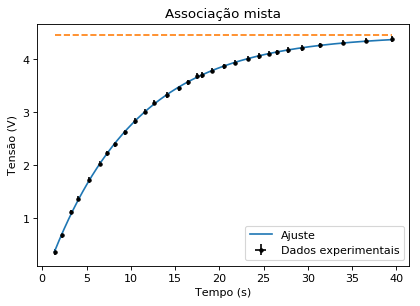

In [138]:
C_mista = lambda C1, C2, C3 : C1*(C2+C3)/(C1+C2+C3)
mista_esp = 92.42
mista_med = C_mista(C1, C2, C3)

fdados = 'data/A-mista-100-220-1000.dat'

V0,RC,C,t0 = analise_carga(fdados,R_tarefa1,mista_esp)
graf_carga(fdados,RC,V0,t0,-1,80,'Associação mista')

print("Valor esperado nominal: {} μF\nValor esperado pelas capacitancias: {}μF".format(mista_esp, mista_med))
print("Valor obtido: {}μF".format(C*1e6))
print("RC =",RC,"s")
print("t0 =",t0,"s")

# Tarefa 3 - Análise do produto RC
Analisar a variação no tempo de vida de um capacitor para uma associação de resistor com um capacitor.

Equação de descarga de um capacitor:
$$V(t)=V_0\mathrm{e}^{-t/RC}$$

Equação para regressão linear:
$$\log(V(t))=\log(V_0)-\dfrac{t}{RC}$$

Aqui não há necessidade de preocupação com $V_0$, que não precisa ser subtraído, nem com $t_0$, que não influencia o coeficiente angular da reta.

## 3.1 Resistores utilizados:
- $100 \mathrm{k}\Omega$
- $68 \mathrm{k}\Omega$
- $47 \mathrm{k}\Omega$
<br><br> E um capacitor fixo de 220 μF (C2 ali em cima).

In [139]:
C_tarefa3 = C2 # em uF
R1 = R100
R2 = M((68.1e3,err_r(68.1e3)))
R3 = M((47.8e3,err_r(68.1e3)))
print("C = {:.2f}μF\nR1 = {:.1f}kΩ\nR2 = {:.1f}kΩ\nR3 = {:.1f}kΩ".format(C_tarefa3, R1*1e-3, R2*1e-3, R3*1e-3))

C = 224±6 μF
R1 = 102.3±0.8 kΩ
R2 = 68.1±0.6 kΩ
R3 = 47.8±0.6 kΩ


## 3.2 Esquema do circuito
<img src="RC.png" width="500px" />

## 3.3 Procedimento experimental: 
Medir a resistência com um ohmimetro;<br> O capacitor é carregado;<br> Após montado o circuito acima, é fechado a chave e, ao mesmo tempo, disparado o cronômetro. Estes valores serão filmados com uma câmera de celular para ser feito a análise dos dados;

## 3.4 Análise dos resultados

Capacitor usado: 224±6  μF

Resistor de 47 kΩ:
-1/RC = -0.0940714838868
log(V0) = 1.46055094406
Capacitância: 222±3  μF

Resistor de 68 kΩ:
-1/RC = -0.0662884389808
log(V0) = 1.45925935528
Capacitância: 222±3  μF

Resistor de 100 kΩ:
-1/RC = -0.0441758751138
log(V0) = 1.42605567991
Capacitância: 221±2  μF



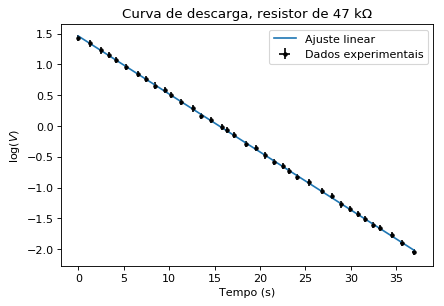

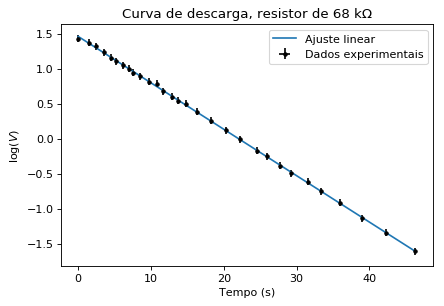

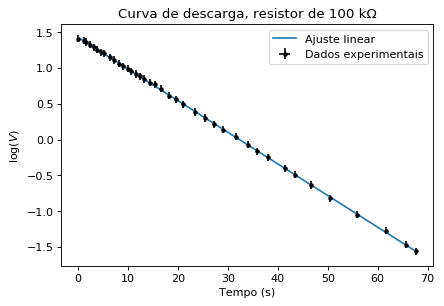

In [144]:
print('Capacitor usado:',C_tarefa3,'μF\n')
resistores_tarefa3 = [(R3,47e3,'data/RC-47k.dat'),
                      (R2,68e3,'data/RC-68k.dat'),
                      (R1,100e3,'data/RC-100k.dat')]
err_logv = lambda v: err_v(v)/v

# fdados: string, nome de arquivo
# R: medida, resistência usada
# retorna coeficientes angular e linear e capacitância equivalente
def analise_descarga(fdados,R):
    t,v = np.loadtxt(fdados).T
    
    # v = a*t + b, a = -1/RC, b = log(V0)
    a, b, r,p, std_a = stats.linregress(t, np.log(v))
    RC = -1*M((a,std_a))**-1
    C = RC/R
    return a,b,C

def graf_descarga(fdados,R,C,a,b,Rnom,dpi=80):
    t,v = np.loadtxt(fdados).T
    logv = np.log(v)
    errot,errologv = err_t(t),err_logv(v)
    
    fig = plt.figure(dpi=dpi)
    plt.errorbar(t,logv,errot,errologv,'.k',label='Dados experimentais')
    tn = np.linspace(t[0],t[-1],1000)
    plt.plot(tn,a*tn+b,label='Ajuste linear')
    plt.legend()
    plt.title("Curva de descarga, resistor de {} kΩ".format(int(Rnom*1e-3)))
    plt.xlabel('Tempo (s)')
    plt.ylabel('$\log (V)$')
    
    return fig

for R, Rnom, fdados in resistores_tarefa3:
    a,b,C = analise_descarga(fdados,R)
    
    print("Resistor de",int(Rnom*1e-3),"kΩ:")
    print("-1/RC =",a)
    print("log(V0) =",b)
    print("Capacitância:",1e6*C,"μF\n")
    
    graf_descarga(fdados,R,C,a,b,Rnom)

# Tarefa 4 - Análise da energia num circuito capacitivo
Calcular a energia inicial e final num circuito capacitivo.

## 4.1 Capacitores utilizados (C2)
C1 será fixo: 10.55 μF; Resistência associada: $100~\mathrm{k}\Omega$
- $1~\mu\mathrm{F}$ (capacimetro)
- $3,3~\mu\mathrm{F}$ (capacimetro)
- $10~\mu\mathrm{F}$ (capacimetro)
- $100~\mu\mathrm{F}$ (curva de carga)
- $220~\mu\mathrm{F}$ (curva de carga)

## 4.2 Esquema do circuito
<img src="4.png" width="600px" />

## 4.3 Procedimento experimental


Medir a capacitância de C1 com um capacimetro; <br>
Carregar o capacitor com uma fonte de 5V;

A energia inicial é dada por $\dfrac{1}{2}C_1\Delta V_i^2$

Desconsiderando dissipações pelas resistências, a energia final é $\dfrac{1}{2}(C_1+C_2)\Delta V_f^2$

Com valores de energia inicial e final por capacitancia obtemos uma reta que relaciona estes valores


Regressão linear:
intercept: 0.8802834804931283, slope: 0.9646571372889402


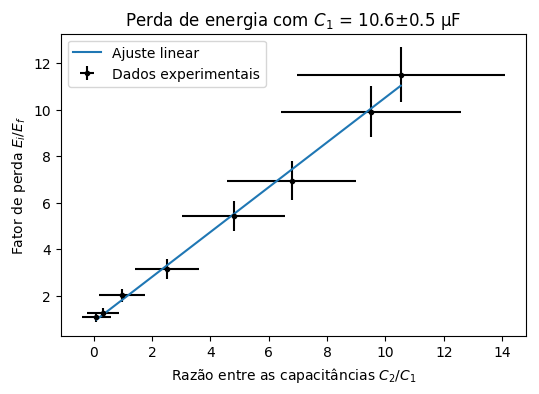

In [151]:
err_c = lambda x: 0.05*x + 2e-6 # na escala de 200 uF
err_c20 = lambda x: 0.025*x + 2e-7 # na escala de 20 uF

C1_tarefa4 = M((10.55e-6,err_c20(10.55e-6))) # capacímetro
#C1_tarefa4 = res_tarefa1[10][2]             # curva de carga. Incerteza menor

C2,Vi,Vf = np.loadtxt("data/energia.dat").T

erroC2C1 = []
erroEiEf = []
for i in range(len(C2)):
    Ei = lambda Vi : (1/2)*C1_tarefa4*Vi**2
    Ef = lambda Vf, C2: (1/2)*(C1_tarefa4 + C2)*Vf**2
    mC2 = M((C2[i],err_c(C2[i])))
    mVi = M((Vi[i],err_c(Vi[i])))
    mVf = M((Vf[i],err_c(Vf[i])))
    mEi, mEf = Ei(mVi), Ef(mVf,mC2)
    erroC2C1.append((mC2/C1_tarefa4).incerteza)
    erroEiEf.append((mEi/mEf).incerteza)
    
Ei = lambda Vi : (1/2)*C1_tarefa4.nominal*Vi**2
Ef = lambda Vf, C2: (1/2)*(C1_tarefa4.nominal + C2)*Vf**2
slope, intercept, r_value, p_value, std_err = stats.linregress(C2/C1_tarefa4.nominal, Ei(Vi)/Ef(Vf, C2))

plt.figure(dpi=100)
plt.xlabel(r"Razão entre as capacitâncias $C_2/C_1$")
plt.ylabel(r"Fator de perda $E_i/E_f$")
plt.title(r"Perda de energia com $C_1$ = {}μF".format(C1_tarefa4*1e6))
plt.errorbar(C2/C1_tarefa4.nominal, Ei(Vi)/Ef(Vf, C2), erroC2C1, erroEiEf, "k.", label="Dados experimentais")
modelo = lambda x: intercept + slope*x
plt.plot(C2/C1_tarefa4.nominal, modelo(C2/C1_tarefa4.nominal), label="Ajuste linear")
plt.legend(loc=0)

print("\nRegressão linear:\nintercept: {}, slope: {}".format(intercept, slope))

<img src="4grafico.png" width="600px" style="float:left" />